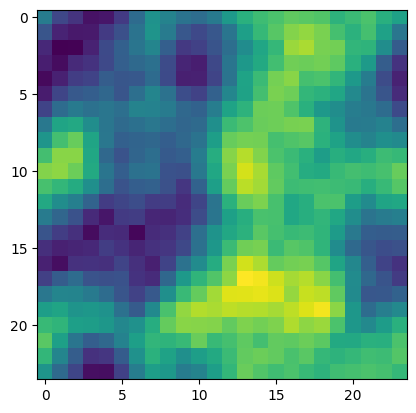

In [62]:
import matplotlib.pyplot as plt

sz = 24
dim = 2
exponent = -2

import numpy as np

# white noise signal
white_noise_signal = np.random.normal(0, 1, size=(sz,) * dim)

# create Fourier filter
# first create a line with squared distances from mid-point
# np.ones(sz)
# for i in range(sz):
#     dist[i] = np.linalg.norm(i - sz/2 - 1)**2

distance_to_center = (np.arange(sz) - sz/2 - 1)**2
squared_distances_added = np.meshgrid(distance_to_center,distance_to_center)
dist_tot = np.sqrt(sum(squared_distances_added))

dist_tot[dist_tot==0] = 1
filt = dist_tot**(exponent*dim/2)

# # Fourier transform white noise, then fftshift to shift 0-frequency
# # to the center of the array, to align with filter whose
# # 0-frequency is also at the center. Otherwise multiplying
# # them together will not multiply corresponding elements.
wnf = np.fft.fftshift(np.fft.fftn(white_noise_signal))

# # multiply with frequency filter
wnf_filt = wnf * filt

# # ifftshift to first shift back the Fourier transform
# # to have 0-frequency at the start again. This lets
# # ifftn do inverse Fourier transform correctly
colored_noise_signal = np.real(np.fft.ifftn(np.fft.ifftshift(wnf_filt)))

plt.imshow(colored_noise_signal)

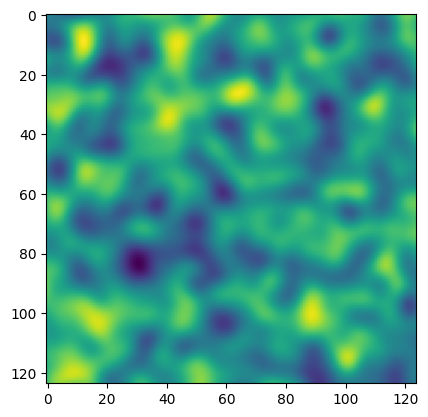

In [115]:
#function [field1,field2,tx,ty]=stationary_Gaussian_process(m,n,rho)
# simulating stationary Gaussian field over an 'm' times 'n' grid
# INPUT:   
#          - 'm' and 'n' for evaluating the field over the m*n grid;
#             note that size of covariance matrix is m^2*n^2;
#          - scalar function rho(h), where 'h' is a two dimensional vector  
#            input and cov(X_t,Y_s)=rho(t-s) is the cov. function of a  
#            2-dimensional stationary Gaussian field; see reference below;
# OUTPUT:  
#          - two statistically independent fields 'field1' and 'field2'
#            over the m*n grid;
#          - vectors 'tx' and 'ty' so that the field is plotted via
#                     imagesc(tx,ty,field1)             
# Example:  
# rho=@(h)((1-h(1)^2/50^2-h(1)*h(2)/(15*50)-h(2)^2/15^2)...
#  *exp(-(h(1)^2/50^2+h(2)^2/15^2))); # define covariance function
#  stationary_Gaussian_process(512,384,rho); # plot when no output wanted   
## Reference:
# Kroese, D. P., & Botev, Z. I. (2015). Spatial Process Simulation.
# In Stochastic Geometry, Spatial Statistics and Random Fields(pp. 369-404)
# Springer International Publishing, DOI: 10.1007/978-3-319-10064-7_12

m=n=124

def rho(h_1,h_2,sigma=5):
    return np.exp(- (h_1**2 + h_2**2) / (sigma**2 * 2))

tx = np.arange(n)
ty = np.arange(m)
Rows = np.zeros((m,n))
Cols = np.zeros((m,n))

Rows = rho(tx[:,None] - tx[0], ty[None,:] - ty[0]) # rows of blocks of cov matrix
Cols = rho(tx[0] - tx[:,None], ty[None,:] - ty[0]) # columns of blocks of cov matrix


# # create the first row of the block circulant matrix with circular blocks
# # and store it as a matrix suitable for fft2;
BlkCirc_row = np.concatenate((np.concatenate((Rows, Cols[:,:0:-1]), axis=1), np.concatenate((Cols[:0:-1,:], Rows[:0:-1,:0:-1]), axis=1)), axis=0)

#compute eigen-values
lam = np.real(np.fft.fft2(BlkCirc_row))/(2*m-1)/(2*n-1)
if (lam<0).any() and np.abs(np.min(lam[lam<0])) > 10**-15:
    raise ValueError('Could not find positive definite embedding!')
else:
    lam[lam<0] = 0
    lam = np.sqrt(lam)

# #generate field with covariance given by block circular matrix
F = np.fft.fft2(lam * (np.random.randn(2*m-1, 2*n-1) + 1j*np.random.randn(2*m-1, 2*n-1)))
F = F[:m, :n] # extract subblock with desired covariance
field1 = np.real(F)
field2 = np.imag(F) # two independent fields with desired covariance

plt.imshow(field1)
plt.show()